Stoner map RPA

max χ0 = 0.456469  |  U_crit ≈ 2.19073  |  U/U_crit = 0.913


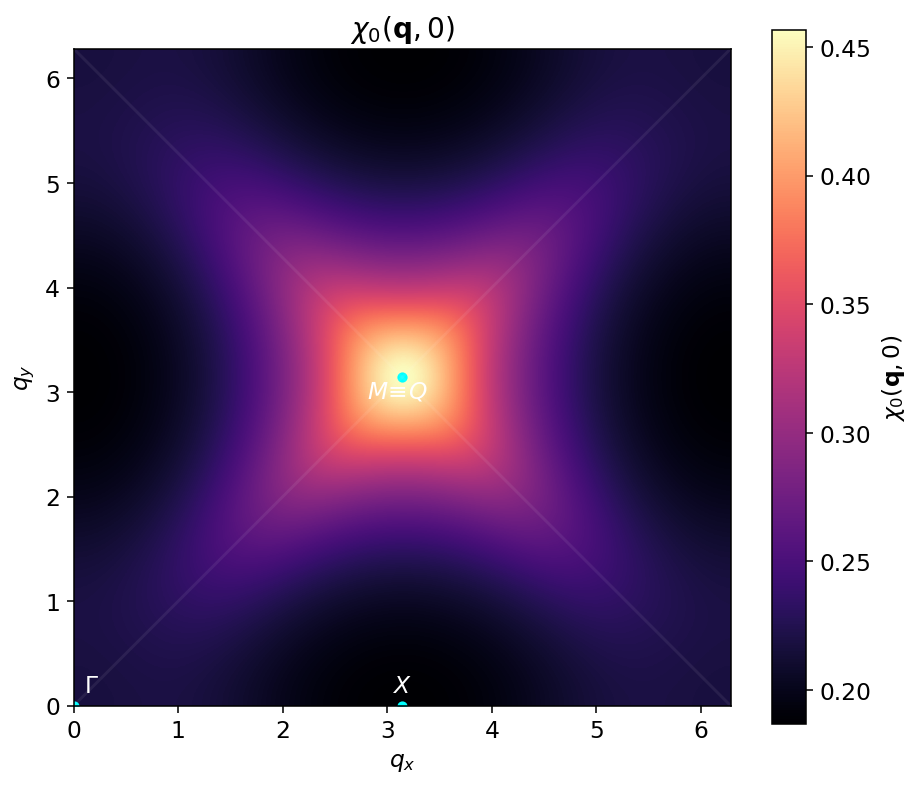

Saved: E:\computation\thesis\code\Optimizing\RPA\chi0_map.png


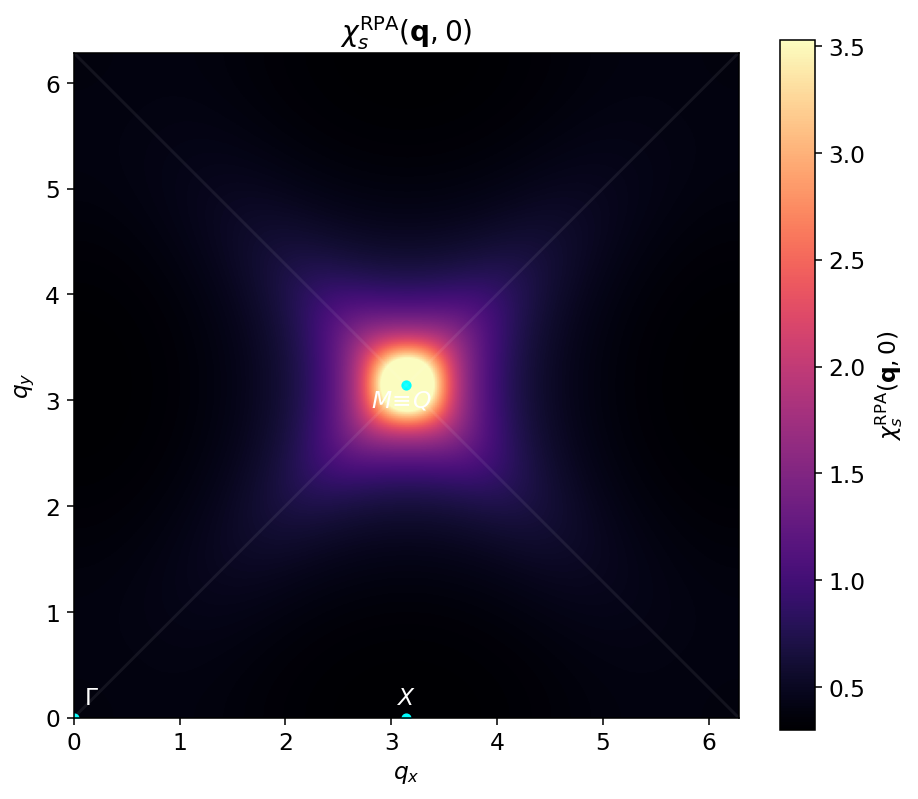

Saved: E:\computation\thesis\code\Optimizing\RPA\chis_rpa_map.png


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

plt.rcParams['figure.dpi'] = 140
plt.rcParams['text.usetex'] = False
plt.rcParams['font.size'] = 12

# --- user parameters (tweak these) ---
Nk   = 361        # odd keeps Γ,X,M exactly on-grid
beta = 4.0        # temperature = 1/beta
U    = 2.0        # choose so that U < Ucrit to avoid the Stoner pole saturating the plot
t    = 1.0
mu   = 0.0
out_dir = Path("./")  # where to save PNGs

def kgrid(n):
    ax = np.linspace(0.0, 2*np.pi, n, endpoint=False)
    return np.meshgrid(ax, ax, indexing='xy')

def eps_k(kx, ky, t=1.0, mu=0.0):
    return -2.0*t*(np.cos(kx) + np.cos(ky)) - mu

def fermi(x, beta):
    xb = np.clip(beta*x, -700, 700)
    return 1.0/(1.0 + np.exp(xb))

def chi0_map(beta, Nk, t=1.0, mu=0.0, atol=1e-12):
    kx, ky = kgrid(Nk)
    ek = eps_k(kx, ky, t=t, mu=mu)
    fk = fermi(ek, beta)
    chi0 = np.zeros((Nk, Nk), dtype=np.float64)
    # roll-based shift: k -> k+q on the discrete mesh
    for n in range(Nk):           # qy index
        ek_n = np.roll(ek, n, axis=0)
        fk_n = np.roll(fk, n, axis=0)
        for m in range(Nk):       # qx index
            ek_q = np.roll(ek_n, m, axis=1)
            fk_q = np.roll(fk_n, m, axis=1)
            de   = ek_q - ek
            num  = fk - fk_q
            out  = np.zeros_like(de)
            mask = np.isclose(de, 0.0, atol=atol)
            out[~mask] = num[~mask]/de[~mask]
            out[mask]  = beta * fk[mask]*(1.0 - fk[mask])   # -f'(ε)
            chi0[n, m] = np.mean(out)
    return chi0

def chi_s_rpa(chi0, U):
    denom = 1.0 - U*chi0
    tiny  = 1e-12
    denom = np.where(np.abs(denom) < tiny, np.sign(denom)*tiny, denom)
    return chi0/denom

def _annotate_symmetry_points():
    # marks Γ=(0,0), X=(π,0), M=(π,π)
    plt.scatter([0, np.pi, np.pi], [0, 0, np.pi], s=18, c="cyan")
    plt.text(0.10, 0.13, r"$\Gamma$", color="white")
    plt.text(np.pi, 0.13, r"$X$", color="white", ha="center")
    plt.text(np.pi-0.05, np.pi-0.20, r"$M\!\equiv\!Q$", color="white", ha="center")

def show_map_save(Z, title, cbar_label, fname, vmin=None, vmax=None, cmap="magma"):
    extent = [0, 2*np.pi, 0, 2*np.pi]
    fig = plt.figure(figsize=(6.8, 5.8))
    im = plt.imshow(Z, origin="lower", extent=extent, aspect="equal", cmap=cmap,
                    vmin=vmin, vmax=vmax)
    cbar = plt.colorbar(im)
    cbar.set_label(cbar_label)
    plt.xlabel(r"$q_x$")
    plt.ylabel(r"$q_y$")
    plt.title(title)
    # faint diagonal guides (nesting rays)
    x = np.linspace(0, 2*np.pi, 1000)
    plt.plot(x, x, color="w", alpha=0.07)
    plt.plot(x, 2*np.pi - x, color="w", alpha=0.07)
    _annotate_symmetry_points()
    plt.tight_layout()
    path = out_dir / fname
    plt.savefig(path, dpi=300, bbox_inches="tight")
    plt.show()
    print("Saved:", path.resolve())

# --- compute and save ---
chi0 = chi0_map(beta=beta, Nk=Nk, t=t, mu=mu)
Ucrit = 1.0/np.max(chi0)
print(f"max χ0 = {chi0.max():.6g}  |  U_crit ≈ {Ucrit:.6g}  |  U/U_crit = {U/Ucrit:.3f}")

show_map_save(
    chi0,
    title=r"$\chi_{0}(\mathbf{q},0)$",
    cbar_label=r"$\chi_{0}(\mathbf{q},0)$",
    fname="chi0_map.png"
)

chis = chi_s_rpa(chi0, U=U)
# Clip color limits to avoid the Stoner ring blowing out the colormap
hi = np.nanpercentile(chis, 99.5)
lo = np.nanpercentile(chis,  0.5)
show_map_save(
    chis,
    title=r"$\chi^{\mathrm{RPA}}_{s}(\mathbf{q},0)$",
    cbar_label=r"$\chi^{\mathrm{RPA}}_{s}(\mathbf{q},0)$",
    fname="chis_rpa_map.png",
    vmin=lo, vmax=hi
)


In [2]:
import numpy as np

# assumes you already computed chi0 (Nk×Nk) and chis = chi_s_rpa(chi0, U)

Nk = chi0.shape[0]
Ucrit = 1.0 / np.max(chi0)
idx_max = np.unravel_index(np.argmax(chis), chis.shape)
qy_idx, qx_idx = idx_max
qx = 2*np.pi*qx_idx/Nk
qy = 2*np.pi*qy_idx/Nk

def at_Gamma(A): return float(A[0,0])
def at_Q(A):     return float(A[Nk//2, Nk//2])

print(f"max χ0 = {np.max(chi0):.6g},  Ucrit ≈ {Ucrit:.6g},  U/Ucrit = {U/Ucrit:.3f}")
print(f"argmax χs^RPA at (qx, qy) = ({qx:.3f}, {qy:.3f})  ~  ({np.pi:.3f}, {np.pi:.3f})")
print(f"χs^RPA(Γ) = {at_Gamma(chis):.6g},  χs^RPA(Q) = {at_Q(chis):.6g}")


max χ0 = 0.456469,  Ucrit ≈ 2.19073,  U/Ucrit = 0.913
argmax χs^RPA at (qx, qy) = (3.133, 3.150)  ~  (3.142, 3.142)
χs^RPA(Γ) = 0.384667,  χs^RPA(Q) = 5.24302
